In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [168]:
words = open("../names.txt").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:5])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [169]:
alphabet = ["."] + list("abcdefghijklmnopqrstuvwxyz")
stoi = {c: i for i, c in enumerate(alphabet)}
itos = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(itos)

In [170]:
block_size = 3
def build_dataset(words):
    random.seed(42)
    random.shuffle(words)
    
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))

    Xtr, Ytr = X[:n1], Y[:n1]
    Xdev, Ydev = X[n1:n2], Y[n1:n2]
    Xte, Yte = X[n2:], Y[n2:]

    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

Xtr, Ytr, Xdev, Ydev, Xte, Yte = build_dataset(words)

In [171]:
#  to compare manual and backprop grads
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    meandiff = (dt - t.grad).abs().mean().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff} | meandiff: {meandiff}")

In [183]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), dtype=torch.float64)

# layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), dtype=torch.float64, generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, dtype=torch.float64, generator=g) * 0.1 # using b1 just for demo - it is useless because of batchnorm

# layer 2
W2 = torch.randn((n_hidden, vocab_size), dtype=torch.float64, generator=g) * 0.1
b2 = torch.randn(vocab_size, dtype=torch.float64, generator=g) * 0.1

# batchnorm params
bngain = torch.randn((1, n_hidden), dtype=torch.float64) * 0.1 + 1
bnbias = torch.randn((1, n_hidden), dtype=torch.float64) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [215]:
# construct a minibatch
batch_size = 32

batch_ixs = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[batch_ixs], Ytr[batch_ixs]

In [216]:
# forward pass "chunked" into smaller steps that are easier to backward one at a time

emb = C[Xb]
# concatenate the vectors
embcat = emb.view((emb.shape[0], -1))
# linear layer 1
hprebn = embcat @ W1 + b1
# batchnorm layer
bnmeani = 1 / batch_size * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = (
    1 / (batch_size - 1) * (bndiff2).sum(0, keepdim=True)
)  # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# non-linearity
h = torch.tanh(hpreact)

# linear layer 2
logits = h @ W2 + b2

# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract maxes for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

# pytorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb,
]:
    t.retain_grad()
loss.backward()
loss


tensor(3.3570, dtype=torch.float64, grad_fn=<NegBackward0>)

In [223]:
# exercise 1: backprop through whole thing manually

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1 / batch_size 
cmp("logprobs", dlogprobs, logprobs)
#
dprobs = dlogprobs * (1 / probs)
cmp("probs", dprobs, probs)
#
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True) # need to sum to have dims match (using same value "multiple times")
dcounts = counts_sum_inv * dprobs # also do this contribution now - the other will come later
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
# 
dcounts_sum = dcounts_sum_inv * (-counts_sum **  -2)
cmp("counts_sum", dcounts_sum, counts_sum)
#
dcounts += torch.ones_like(counts) * dcounts_sum # second contribution adds
# we multiply by dcounts_sum here since counts_sum is a pure addition which acts like a "router" for gradients
# simply pushing the gradient through horizontally 
cmp("counts", dcounts, counts)
#
dnorm_logits = dcounts * norm_logits.exp()
cmp("norm_logits", dnorm_logits, norm_logits)
#
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits.clone()).sum(1, keepdim=True)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
#
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp("logits", dlogits, logits)
#
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
#
dhpreact = (1 - h ** 2) * dh
cmp("hpreact", dhpreact, hpreact)
#
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
cmp("bngain", dbngain, bngain)
cmp("bnraw", dbnraw, bnraw)
cmp("bnbias", dbnbias, bnbias)
#
dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
#
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
cmp("bnvar", dbnvar, bnvar) 
#
dbndiff2 = (1 / (batch_size - 1)) * torch.ones_like(bndiff) * dbnvar
cmp("bndiff2", dbndiff2, bndiff2)
#
dbndiff += 2 * bndiff * dbndiff2
cmp("bndiff", dbndiff, bndiff)
#
dhprebn = dbndiff.clone()
dbnmeani = -dbndiff.sum(0, keepdim=True)
cmp("bnmeani", dbnmeani, bnmeani)
#
dhprebn += (1 / batch_size) * torch.ones_like(hprebn) * dbnmeani
cmp("hprebn", dhprebn, hprebn)
#
dW1 = embcat.T @ dhprebn
dembcat = dhprebn @  W1.T
db1 = dhprebn.sum(0)
cmp("W1", dW1, W1)
cmp("embcat", dembcat, embcat)
cmp("b1", db1, b1)
#
demb = dembcat.view(emb.shape) 
cmp("emb", demb, emb)
#
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j] 
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0 | meandiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 8.673617379884035e-19 | 

In [225]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).abs().item())

3.3570301407917964 diff: 0.0


In [226]:
dlogits_fast = F.softmax(logits, 1)
dlogits_fast[range(batch_size), Yb] -= 1
dlogits_fast /= batch_size

cmp("logits fast", dlogits_fast, logits)

logits fast     | exact: False | approximate: True  | maxdiff: 1.3877787807814457e-17 | meandiff: 3.5889099691071095e-19


tensor(-8.6736e-19, dtype=torch.float64)


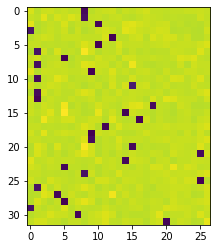

In [234]:
print(dlogits.detach()[0].sum()) # should sup to something zero (or very close)
plt.imshow(dlogits.detach());
# an analogy that is useful here is that of a force that pushes down the incorrect probabilities
# and pulls up the correct example (the integral of the force would be zero - all balanced)

In [233]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(8.8818e-16, dtype=torch.float64, grad_fn=<MaxBackward1>)
